## 1 - Import


In [1]:
import base64
import utils
# import imageio
# import IPython
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from itertools import zip_longest
from collections import deque, namedtuple

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Lambda, Conv1D
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from statsmodels.iolib.table import SimpleTable



## 2 - Hyperparameters
Run the cell below to set the hyperparameters.

In [2]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.996              # discount factor
ALPHA = 5e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

BETA_BUY = 1              # Percentage of maximum buy quantity can be executed
BETA_SELL = 1             # Percentage of maximum sell quantity can be executed
trading_fee_rate = 0.001
holding_penalty = 3e-5
exploratory_reward = 5e-4

## 3 - Coinworld Evironment
The goal of Coinworld evironment is to earn profit and maintain it from foreign exchange. Agent is only allow to trade and hold 1 currency at a time.

In [5]:
import numpy as np
import random

class Coinworld:
    """
    To create a mock trading environment.
    """

    def __init__(self, series, initial_balance=10, min_trading=10, trading_fee_rate=0.001, exploratory_reward=0.01, holding_penalty=0.001, profit_threshold=20, loss_threshold=5, min_cash_balance=1):
        """
        State = (
            Holding quantity,
            Average price,
            Cash balance,
            Market price,
            Other indicators,
        )
        """
        self.series = series
        self.initial_balance = initial_balance
        self.min_trading = min_trading
        self.trading_fee_rate = trading_fee_rate
        self.exploratory_reward = exploratory_reward
        self.holding_penalty = holding_penalty
        self.profit_threshold = profit_threshold
        self.loss_threshold = loss_threshold
        self.min_cash_balance = min_cash_balance
        self.reset()

    def reset(self):
        market_price_0 = self.series[0, 0]
        self.time_stamp = 0

        buy_limit = self.initial_balance / market_price_0
        hold_qty = float(random.randint(0, 1) * buy_limit)
        avg_price = 0 if hold_qty == 0 else market_price_0
        cash_balance = self.initial_balance - hold_qty * avg_price
        hold_duration = 0

        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        self.prev_acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        self.market_state = tuple(self.series[0])

        self.state = self.acc_state + tuple(self.series[0])
        self.prev_state = self.state

        self.goal = tuple(self.series[-1])
        self.done = len(self.series) <= 1
        return np.array(self.state)

    def update_state(self):
        hold_qty_0, avg_price_0, cash_balance_0, hold_duration_0 = self.prev_acc_state
        hold_qty, avg_price, cash_balance, hold_duration = self.acc_state

        if hold_qty_0 == hold_qty:
            hold_duration += 1
        else:
            hold_duration = 0

        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)

        self.time_stamp += 1
        self.prev_market_state = self.market_state
        self.market_state = tuple(self.series[self.time_stamp])
        self.state = self.acc_state + self.market_state

    def Buy(self):
        hold_qty, avg_price, cash_balance, hold_duration = self.acc_state

        if cash_balance < self.min_cash_balance:
            print("Insufficient cash balance to perform buy action.")
            return False

        market_price = self.market_state[0]
        buy_price = market_price * (1 + self.trading_fee_rate)
        buy_limit = cash_balance / buy_price
        buy_qty = buy_limit  # Example: buy half of the limit

        avg_price = (hold_qty * avg_price + buy_price * buy_qty) / (hold_qty + buy_qty)
        hold_qty += buy_qty
        cash_balance -= buy_qty * buy_price

        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)
        return True

    def Sell(self):
        hold_qty, avg_price, cash_balance, hold_duration = self.acc_state

        market_price = self.market_state[0]
        sell_price = market_price * (1 - self.trading_fee_rate)
        sell_qty = hold_qty  # Example: sell half of the holdings

        hold_qty -= sell_qty
        cash_balance += sell_qty * sell_price

        self.acc_state = (hold_qty, avg_price, cash_balance, hold_duration)

    def get_reward(self):
        hold_qty_1, avg_price_1, cash_balance_1, hold_duration_1 = self.acc_state
        hold_qty_0, avg_price_0, cash_balance_0, hold_duration_0 = self.prev_acc_state
        market_price = self.market_state[0]
        prev_market_price = self.prev_market_state[0]

        previous_value = hold_qty_0 * prev_market_price + cash_balance_0
        current_value = hold_qty_1 * market_price + cash_balance_1
        reward = current_value - previous_value
        # reward += self.exploratory_reward * current_value
        # reward -= current_value * hold_duration_1 * self.holding_penalty

        return reward

    def step(self, action):
        if self.done:
            print('No more steps can be taken')
            return np.array(self.state), 0, self.done

        hold_qty, avg_price, cash_balance, *market_state = self.state
        self.prev_state = self.state

        if action == 1:
            if cash_balance >= self.min_cash_balance:
                success = self.Buy()
                if not success:
                    reward = -self.exploratory_reward  # Penalize for trying to buy with insufficient funds
            else:
                reward = -self.exploratory_reward
        elif action == 2 and hold_qty > 0:
            self.Sell()
        else:
            reward = 0  # Penalize for invalid actions or doing nothing

        self.update_state()
        reward = self.get_reward() if action in [1, 2] else reward

        if self.time_stamp >= len(self.series) - 1:
            self.done = True

        current_balance = hold_qty * self.market_state[0] + cash_balance
        if current_balance >= self.profit_threshold or current_balance <= self.loss_threshold:
            self.done = True

        self.prev_acc_state = self.acc_state

        return np.array(self.state), reward, self.done

    def get_state_space_size(self):
        return np.array(self.state).shape

    def get_action_space_size(self):
        return 3


In [4]:
input = pd.read_pickle(r'C:\Users\Dell\OneDrive\Documents\projects\trading_bot_v0\Processed_Dataset_from_1Jan22_17Feb24.pkl') # Importing dataset from pickle
series = np.array(input[['close','RSI']][-2000:]) # Choosing last 1000 data points in close column
env = Coinworld(series)


<a name="6"></a>
## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

In [6]:
state_size = env.get_state_space_size()
num_actions = env.get_action_space_size()

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    # Lambda(lambda q_values: tf.expand_dims(tf.reduce_max(q_values, axis=1), axis=1))
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    # Lambda(lambda q_values: tf.expand_dims(tf.reduce_max(q_values, axis=1), axis=1))
    ])

optimizer = Adam(learning_rate=ALPHA)


In [7]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [8]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values) 
    ### END CODE HERE ### 
    
    return loss

In [9]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

###  Optimistic Initial Values - Local Minima and Maxima

Local maxima indices: [  63  202  346  469  571  705  842  953 1067 1179 1280 1447 1548 1657
 1820 1955]
Local maxima values: [52044.01171875 51959.7890625  51795.76171875 51783.83984375
 51592.69921875 51161.03125    51254.6015625  51434.
 52009.578125   51636.8515625  51792.94921875 51461.98828125
 51683.94921875 51738.37890625 52051.98828125 51865.        ]
Local minima indices: [  99  290  399  529  661  766  872  991 1137 1251 1389 1493 1622 1737
 1890 1991]
Local minima values: [51819.76171875 51744.01171875 51509.98828125 51569.6015625
 50650.03125    50762.01953125 51175.25       51320.01171875
 51597.16015625 51545.48046875 51211.1015625  51524.46875
 51407.44140625 51719.91015625 51720.140625   51547.01171875]


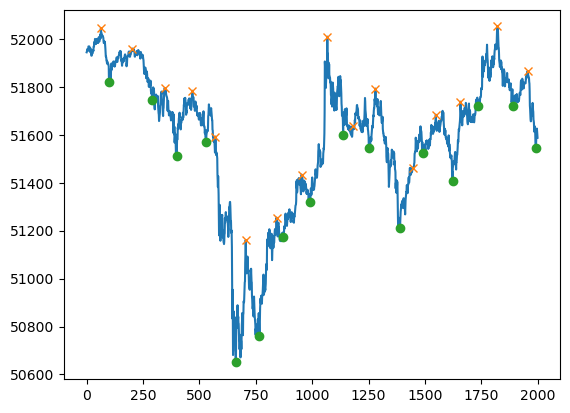

In [10]:
import numpy as np
from scipy.signal import find_peaks

# Example time series data
data = np.array(series[:,0])
# Set prominence and distance
prominence = None
distance = 100
width = 10

# Find local maxima
peaks, _ = find_peaks(data, prominence=prominence, distance=distance)
print("Local maxima indices:", peaks)
print("Local maxima values:", data[peaks])

# Find local minima by inverting the signal
min_peaks, _ = find_peaks(-data, prominence=prominence, distance=distance)
print("Local minima indices:", min_peaks)
print("Local minima values:", data[min_peaks])

plt.plot(series[:,0])
plt.plot(peaks, data[peaks], "x")
plt.plot(min_peaks, data[min_peaks], "o")
plt.show()

In [11]:
# Buy at the local minima and sell at the local maxima
action_ini = np.array([0] * 2000)
# print([i for i in action_ini])
action_ini[list(peaks)] = 2
action_ini[list(min_peaks)] = 1


In [28]:
# Reset the environment to the initial state and get the initial state
state = env.reset()
total_points = 0
max_num_timesteps = 2000

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# action_ini = [1, 2] * 1000
for t in range(max_num_timesteps):
        
    # From the current state S choose an action A using an ε-greedy policy
    state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
    try:
        q_values = q_network(state_qn)
    except Exception as e:
        print(e, state_qn)

    action = action_ini[t]
    
    # Take action A and receive reward R and the next state S'
    # next_state, reward, done, _ = env.step(action)
    next_state, reward, done = env.step(action)
    
    # Store experience tuple (S,A,R,S') in the memory buffer.
    # We store the done variable as well for convenience.
    memory_buffer.append(experience(state, action, reward, next_state, done))
    
    # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
    update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
    
    if update:
        # Sample random mini-batch of experience tuples (S,A,R,S') from D
        experiences = utils.get_experiences(memory_buffer)
        
        # Set the y targets, perform a gradient descent step,
        # and update the network weights.
        agent_learn(experiences, GAMMA)
    
    state = next_state.copy()
    total_points += reward
    
    if done:
        break

print(f"\rTotal point in the first episodes: {total_points:.2f}", end="")


Total point in the first episodes: 3.66

In [14]:
start = time.time()

num_episodes = 1000
max_num_timesteps = 2000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights()) 

In [15]:


for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        try:
            q_values = q_network(state_qn)
        except Exception as e:
            print(e, state_qn)

        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 2000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('trading_model_1.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 21 | Total point average of the last 100 episodes: 72.80

KeyboardInterrupt: 

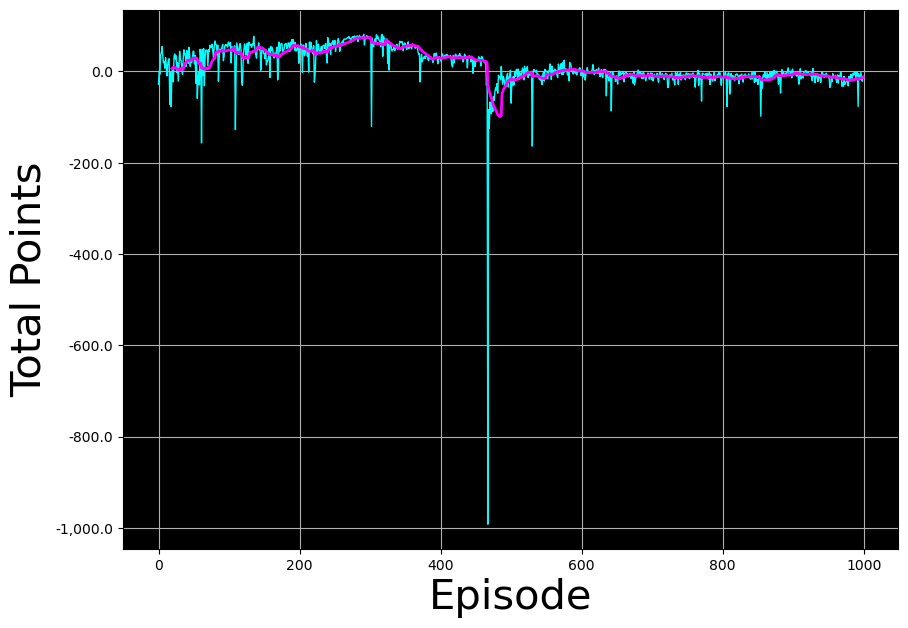

In [12]:
# Plot the point history
utils.plot_history(total_point_history)

In [ ]:
q_network.save('trading_model_2.h5')